<a href="https://colab.research.google.com/github/lamazakaria/Hand_Gesture_Recognition/blob/main/Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hand-gesture-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1571228%2F2586549%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240809%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240809T201727Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3613a463f1610c70bdd171094b1e4efb528c110c4b0fc3c77beccecbca0efa1e50b23090f6f4ddd5a6e8247e0549b1a8b32d6ee85f330b72de8ffa8ef6efcd2bb2668f35789479babe9a5f68e2554a6c52f2c74eb90879431b899459eeb6524df584c65a1362c2a023e31da79d33eb327022ecefd66190915eca6b7a5cffa130677f4c1a328922cd0c777ccbae1697793360ff1d22997aa7bf6fe2c48709e74a0c536d480b4ae1f24c4f56a332a047af0f5c501d7dd25c7eac26b749848763d9a516db2c486cca541df99ee7d8d9fa7b07f6b3c1c57593c132e7d028c3d1f8e12b85c10ea90a70344030bce2cea881e72a9c8db6c36d9960eb2326f1fc86b28d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import glob
import os
import cv2
import random
import tensorflow as tf
import numpy as np
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model,activations,callbacks,optimizers
from tensorflow.keras.layers import Dense, LSTM, Flatten ,Activation , Dropout, BatchNormalization, SimpleRNN

2024-08-09 16:58:19.625995: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 16:58:19.626054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 16:58:19.627686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
x_train = glob.glob('/kaggle/input/hand-gesture-recognition-dataset/train/train/*/*')
x_test = glob.glob('/kaggle/input/hand-gesture-recognition-dataset/test/test/*/*')
print(f"length test:{len(x_test)}")
print(f"length train:{len(x_train)}")


length test:6000
length train:18000


In [ ]:
validation_split = 0.2
validation_length = int(validation_split*len(x_train))
indices = np.random.choice(len(x_train), validation_length,replace=False)
print(validation_length)
x_valid = [x_train[idx] for idx in indices]
x_train = [x_train[idx] for idx in range(len(x_train)) if idx not in indices]


3600


In [ ]:
print(len(x_valid),len(x_train))
print(len(indices))

3600 14400
3600


In [ ]:

random.Random(42)
random.shuffle(x_train)
random.shuffle(x_test)
random.shuffle(x_valid)

In [ ]:
print(x_train[0],x_test[0])

/kaggle/input/hand-gesture-recognition-dataset/train/train/9/652.jpg /kaggle/input/hand-gesture-recognition-dataset/test/test/1/984.jpg


In [ ]:
batch_size=32
epochs = 40



In [ ]:
def extract_label(path):
    path = path.decode()
    components = path.split('/')
    label = components[-2]
    label = tf.strings.to_number(label, out_type=tf.int32)
    return tf.cast(label,tf.uint8)




In [ ]:
def extract_contours(img_path):
    img_path = img_path.decode()
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or unable to load.")
    img = cv2.resize(img,(100,100))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     print(f"image:{img.shape}")
    img_edges = cv2.Canny(img,100,180)

    contours,_ = cv2.findContours(img_edges,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     concetaneted_contours = np.concatenate(contours,axis=0)
#     concetaneted_contours =concetaneted_  contours.reshape(-1,2)
    concetenated_contours = np.concatenate([contour.reshape(-1, 2) for contour in contours], axis=0)
    concetenated_contours = concetenated_contours.astype(np.float32) / 255.0
    return concetenated_contours



In [ ]:
def read_data(data):
    label = tf.numpy_function(extract_label,[data],tf.uint8)
    label = tf.reshape(label,())
    features = tf.numpy_function(extract_contours,[data],tf.float32)
    return features , label


In [ ]:
def extract_max_features(features):
    return  tf.shape(features)[0]


In [ ]:
def prepare_data(data):
    paddedshape = ([None,2],[])
    max_no_features = 0
    dataset = Dataset.from_tensor_slices(data)
    dataset = dataset.map(read_data)
    for features, label in dataset:
        max_no_features = tf.maximum(max_no_features,extract_max_features(features))

    dataset = dataset.padded_batch(batch_size,paddedshape)
    dataset = dataset.prefetch(10)
    return dataset, max_no_features


In [ ]:
train_dataset, max_no_features_train = prepare_data(x_train)
test_dataset, max_no_features_test = prepare_data(x_test)
valid_dataset, max_no_features_valid = prepare_data(x_valid)

In [ ]:
for feature, label in train_dataset.take(3):
    print("Image shape:", feature.shape)
    print("Label:", label.numpy())

Image shape: (32, 474, 2)
Label: [ 9  5 18  1  9 12 14  0  6 12 10  5 10  5 13  1 10  0 15  7 14 13 12 11
 13 12 10 10 15 11  8  1]
Image shape: (32, 376, 2)
Label: [11  1 12  1  9  1  1  2  1  1 11 19 18  9 15  8 18  8 12  6 19 18 11 19
  2 19 15  0 11 19 11  8]
Image shape: (32, 428, 2)
Label: [ 8  4  8  4  0  7  8 18  9  9 12  4  4 16 15  3 18 13  7 13 16 19  6  7
 11  3 14  4 19  6 16  3]


In [ ]:
print(f"max_no_features:{max_no_features_test,max_no_features_valid,max_no_features_train}")

max_no_features:(<tf.Tensor: shape=(), dtype=int32, numpy=544>, <tf.Tensor: shape=(), dtype=int32, numpy=525>, <tf.Tensor: shape=(), dtype=int32, numpy=530>)


In [ ]:
inputs = Input(shape=(max_no_features_test.numpy(),2))
lstm = LSTM(128,return_sequences =True)(inputs)
x = BatchNormalization()(lstm)
lstm_2  = LSTM(64)(x)
x2 = BatchNormalization()(lstm_2)
output = Dense(20,activation='softmax')(x2)
model = Model(inputs,output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 544, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 544, 128)       │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 544, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,548 (463.08 KB)

 Trainable params: 118,164 (461.58 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
LR = 1e-3
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizers.Adam(LR),metrics=['accuracy'])

In [ ]:
model_history = model.fit(train_dataset,callbacks=callbacks,epochs=epochs,validation_data=valid_dataset,batch_size=batch_size)

Epoch 1/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 257s 562ms/step - accuracy: 0.1372 - loss: 2.6271 - val_accuracy: 0.1150 - val_loss: 2.7646 - learning_rate: 0.0010
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 252s 559ms/step - accuracy: 0.2132 - loss: 2.1698 - val_accuracy: 0.1711 - val_loss: 2.8865 - learning_rate: 0.0010
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 252s 561ms/step - accuracy: 0.2797 - loss: 1.9814 - val_accuracy: 0.2636 - val_loss: 2.6148 - learning_rate: 0.0010
Epoch 4/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 253s 561ms/step - accuracy: 0.4251 - loss: 1.5279 - val_accuracy: 0.2983 - val_loss: 2.2191 - learning_rate: 0.0010
Epoch 5/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 254s 565ms/step - accuracy: 0.5201 - loss: 1.2564 - val_accuracy: 0.3733 - val_loss: 1.9238 - learning_rate: 0.0010
Epoch 6/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 253s 561ms/step - accuracy: 0.6358 - loss: 1.0063 - val_accuracy: 0.2722 - val_loss: 3.6688 - learning_rate: 0.0010
Epoch 7/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 259s 553ms/step - accura

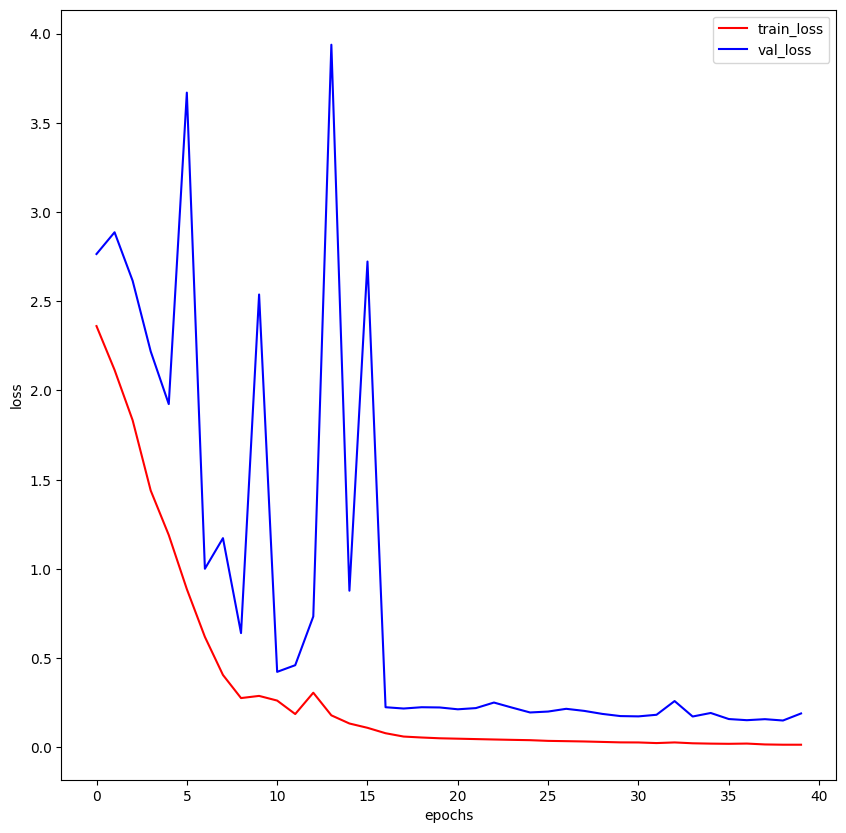

In [ ]:
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.figure(figsize=(10,10))
plt.plot(loss,color='r',label='train_loss')
plt.plot(val_loss,color='b',label="val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.show()


In [ ]:
result = model.evaluate(test_dataset)
print(f"Loss:{result[0]}")
print(f"Accuarcy:{result[1] * 100}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.9191 - loss: 0.2778
Loss:0.2629503011703491
Accuarcy:92.4833357334137%
